In [259]:
%load_ext autoreload
%autoreload 2

import sys
import os

from string import digits
import pandas as pd
import geopandas as gpd

sys.path.append('../src/construct/')
import util, geoutil, annual_subnational_demand

NUTS_3 = "https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_03M_{}_4326_LEVL_3.geojson"

idx = pd.IndexSlice

ch_canton_to_nuts3 = {
    'AG': 'CH033',
    'AI': 'CH054',
    'AR': 'CH053',
    'BE': 'CH021',
    'BL': 'CH032',
    'BS': 'CH031',
    'FR': 'CH022',
    'GE': 'CH013',
    'GL': 'CH051',
    'GR': 'CH056',
    'JU': 'CH025',
    'LU': 'CH061',
    'NE': 'CH024',
    'NW': 'CH065',
    'OW': 'CH064',
    'SG': 'CH055',
    'SH': 'CH052',
    'SO': 'CH023',
    'SZ': 'CH063',
    'TG': 'CH057',
    'TI': 'CH070',
    'UR': 'CH062',
    'VD': 'CH011',
    'VS': 'CH012',
    'ZG': 'CH066',
    'ZH': 'CH040'
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [481]:
heat_demand = pd.read_csv('../build/annual_heat_demand.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)
heat_electricity_demand = pd.read_csv('../build/annual_heat_electricity_consumption.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)
industry_demand = pd.read_csv('../build/annual_industry_energy_demand.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)
industry_demand = industry_demand[industry_demand.index.get_level_values('year').isin(range(2000, 2019))]
road_distance = pd.read_csv('../build/annual_road_transport_distance_demand.csv', index_col=[0, 1, 2, 3], squeeze=True)
rail_demand = pd.read_csv('../build/annual_rail_transport_energy_demand.csv', index_col=[0, 1, 2, 3], squeeze=True)
air_demand = pd.read_csv('../build/annual_air_transport_energy_demand.csv', index_col=[0, 1, 2], squeeze=True)

for i in [heat_demand, heat_electricity_demand, industry_demand, road_distance, rail_air_demand]:
    assert isinstance(i, pd.Series)
    
#def alpha2_to_alpha3(df, level):
#    df.index = df.index.set_levels(df.index.levels[level].map(util.get_alpha3), level=level)

In [255]:
freight_df = annual_subnational_demand.load_eurostat_tsv('../data/automatic/freight.tsv.gz', ['subsector', 'unit', 'region'])
gva_df = annual_subnational_demand.load_eurostat_tsv('../data/automatic/gva.tsv.gz', ['unit', 'cat_name', 'region'])
employees_df = annual_subnational_demand.load_eurostat_tsv(
    '../data/automatic/employees.tsv.gz', ['cat_code', 'indicator', 'region'],
    slice_idx='V16110', slice_lvl='indicator'
)
national_population = pd.read_csv('../build/population.csv')
units = gpd.read_file('../build/units.geojson')
nuts_to_eurospores = pd.read_excel('../data/eurospores.xlsx', sheet_name='locations')
nuts_dfs = {}
for i in [2006, 2010, 2016]:
    nuts_dfs[i] = (
        nuts_to_eurospores
        .dropna(subset=[f'NUTS3_{i}'])
        .assign(country_code=nuts_to_eurospores.EuroSPORES.str.split('_', expand=True)[0])
        .set_index(f'NUTS3_{i}')
        [['EuroSPORES', 'country_code']]
        .rename(columns={'EuroSPORES': 'region'})
    )

In [375]:
commercial_df = annual_subnational_demand.subnational_commercial_demand(
    heat_demand, heat_electricity_demand, road_distance, units, nuts_dfs[2016], 
    os.path.abspath('../data/automatic/gva.tsv.gz'), os.path.abspath('../data/automatic/ch_gva.xlsx')
)

In [490]:
industry_df = annual_subnational_demand.subnational_industry_demand(
    units, 
    '../build/annual_industry_energy_demand.csv', 
    road_distance, 
    rail_demand, 
    '../data/industry/all_industrial_ets_eprtr_sites.geojson', 
    '../data/automatic/freight.tsv.gz',
    '../data/automatic/employees.tsv.gz', 
    nuts_dfs[2006], 
    '../data/industry/industry_activity_codes.csv'
)

In [406]:
heat_electricity_demand = (
    heat_electricity_demand
    .unstack('country_code')
    .fillna(0)
    .stack()
    .reorder_levels(heat_electricity_demand.index.names)
)

In [408]:
hh_df = annual_subnational_demand.subnational_pop_weighted_demand(
    units, heat_demand, heat_electricity_demand,
    road_distance, rail_demand, '../build/population.csv'
)

In [429]:
foo = nuts_to_eurospores.dropna(subset=['NUTS3_2006'])
foo = foo.set_index(foo.NUTS3_2006).EuroSPORES
foo.append(nuts_to_eurospores[nuts_to_eurospores.Source != 'NUTS3'].set_index('Country').rename(index=util.get_alpha3).EuroSPORES)

AT322    AUT_1
AT342    AUT_1
AT323    AUT_1
AT335    AUT_1
AT321    AUT_1
         ...  
TUN      TUN_1
LBY      LBY_1
CYP      CYP_1
EGY      EGY_1
ISL      ISL_1
Name: EuroSPORES, Length: 1159, dtype: object

In [492]:
all_df = (
        pd.concat([commercial_df, industry_df, hh_df])
        .groupby(level=['dataset', 'cat_name', 'year', 'id', 'unit', 'end_use']).sum()
    )

In [433]:
all_df.to_csv('../build/eurospores/annual_demand.csv')

In [440]:
all_df

dataset                  cat_name    year    id     unit    end_use      
electricity_heat_demand  commercial  2000.0  ALB_1  twh     cooking              0.108510
                                                            space_heating        0.085356
                                                            water_heating        0.063361
                                             AUT_1  twh     cooking              0.485314
                                                            space_heating        0.335296
                                                                                 ...     
transport_demand         road        2018.0  SWE_4  mio_km  bus                133.968452
                                                            hdv                397.300930
                                                            ldv               1065.340303
                                                            motorcycle         112.002068
                          

In [441]:
air_demand.rename(util.get_alpha3, level='country')

country  year    unit
ALB      1990.0  twh      0.000000
         1991.0  twh      0.000000
         1992.0  twh      0.000000
         1993.0  twh      0.000000
         1994.0  twh      0.000000
                           ...    
CHE      1986.0  twh     10.816667
         1987.0  twh     11.130556
         1988.0  twh     11.850000
         1989.0  twh     12.350000
         2019.0  twh     22.525000
Name: 0, Length: 989, dtype: float64

In [442]:
eurospore_to_country = units.set_index('id').country_code

In [446]:
all_df.loc[all_df.index.get_level_values('unit') == 'twh'] 

dataset                  cat_name    year    id     unit  end_use      
electricity_heat_demand  commercial  2000.0  ALB_1  twh   cooking          0.108510
                                                          space_heating    0.085356
                                                          water_heating    0.063361
                                             AUT_1  twh   cooking          0.485314
                                                          space_heating    0.335296
                                                                             ...   
transport_demand         rail        2018.0  SVN_1  twh   electricity      0.364670
                                             SWE_1  twh   electricity      0.095449
                                             SWE_2  twh   electricity      0.277778
                                             SWE_3  twh   electricity      1.730433
                                             SWE_4  twh   electricity      0.470973
Leng

In [447]:
all_df.loc[all_df.index.get_level_values('unit') == 'twh'] *= 0.0001

In [493]:
all_df.loc[all_df.index.get_level_values('end_use') == 'co2'] 

dataset          cat_name  year    id     unit  end_use
industry_demand  industry  2000.0  ALB_1  kt    co2          2.012582
                                   AUT_2  kt    co2         47.496652
                                   AUT_3  kt    co2          4.988558
                                   BEL_1  kt    co2        159.684707
                                   BGR_1  kt    co2         96.142538
                                                              ...    
                           2018.0  SRB_1  kt    co2         28.314405
                                   SVK_1  kt    co2         37.837402
                                   SVN_1  kt    co2          4.090773
                                   SWE_3  kt    co2         85.327886
                                   SWE_4  kt    co2         11.837712
Length: 1463, dtype: float64

In [489]:
industry_demand.xs('co2', level='carrier')

subsector           country_code  unit  year  
Chemicals Industry  FR            kt    2000.0    229.611046
                                        2001.0    331.633868
                                        2002.0    348.542250
                                        2003.0    437.932776
                                        2004.0    389.864606
                                                     ...    
                    RS            kt    2014.0     31.779278
                                        2015.0     37.813068
                                        2016.0     28.314405
                                        2017.0     28.314405
                                        2018.0     28.314405
Name: 0, Length: 684, dtype: float64

In [456]:
import annual_industry_demand

energy_df = pd.read_csv('../data/industry/jrc_idees_processed_energy.csv.gz', index_col=[0, 1, 2, 3, 4, 5, 6])
prod_df = pd.read_csv('../data/indusztry/jrc_idees_processed_production.csv.gz', index_col=[0, 1, 2, 3])
energy_balances = pd.read_csv('../build/annual_energy_balances.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)
cat_names = pd.read_csv('../data/energy_balance_category_names.csv', header=0, index_col=0)

In [457]:
demand = energy_df.xs('demand').sum(level=['section', 'subsection', 'country_code', 'cat_name', 'unit'])

electrical_consumption = (
    annual_industry_demand.get_carrier_demand('Electricity', demand, energy_df)
    .assign(carrier='electricity').set_index('carrier', append=True)
)
nat_gas_consumption = (
    annual_industry_demand.get_carrier_demand('Natural gas (incl. biogas)', demand, energy_df)
    .drop(electrical_consumption.droplevel('carrier').index, errors='ignore')
    .assign(carrier='natural_gas').set_index('carrier', append=True)
)
diesel_consumption = (
    annual_industry_demand.get_carrier_demand('Diesel oil (incl. biofuels)', demand, energy_df)
    .drop(nat_gas_consumption.droplevel('carrier').index, errors='ignore')
    .drop(electrical_consumption.droplevel('carrier').index, errors='ignore')
    .assign(carrier='oil').set_index('carrier', append=True)
)

In [475]:
all_other_industry_consumption = pd.concat([
    i
    .drop(['Iron and steel', 'Chemicals Industry'], level='cat_name', errors='ignore')
    .drop('Low enthalpy heat', level='subsection', errors='ignore')
    .sum(level=['cat_name', 'country_code', 'unit', 'carrier'])
    for i in [electrical_consumption, nat_gas_consumption, diesel_consumption]
])
all_other_industry_space_heat = (
    demand
    .drop(['Iron and steel', 'Chemicals Industry'], level='cat_name')
    .xs('Low enthalpy heat', level='subsection')
    .sum(level=['cat_name', 'country_code', 'unit'])
    .assign(carrier='space_heating').set_index('carrier', append=True)
)
steel_energy_consumption = annual_industry_demand.get_steel_energy_consumption(energy_df, prod_df)
chem_energy_consumption = annual_industry_demand.get_chem_energy_consumption(electrical_consumption, prod_df, demand)

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [476]:
all_consumption = pd.concat([
    steel_energy_consumption.reorder_levels(all_other_industry_consumption.index.names),
    chem_energy_consumption.reorder_levels(all_other_industry_consumption.index.names),
    all_other_industry_consumption,
    all_other_industry_space_heat
])
all_consumption.columns = all_consumption.columns.astype(int).rename('year')

In [478]:
all_consumption

year                                                             2000  \
cat_name                 country_code unit carrier                      
Iron and steel           FR           ktoe electricity    2650.686541   
                         DK           ktoe electricity     143.609168   
                         CY           ktoe electricity       0.000000   
                         SE           ktoe electricity     768.486369   
                         AT           ktoe electricity     684.844903   
...                                                               ...   
Other Industrial Sectors CZ           ktoe space_heating    11.009905   
                         HR           ktoe space_heating     1.182208   
                         SK           ktoe space_heating     2.312626   
                         PT           ktoe space_heating     8.802571   
                         BE           ktoe space_heating    10.753803   

year                                                             2001  \
cat_name                 country_code unit carrier                      
Iron and steel           FR           ktoe electricity    2528.304058   
                         DK           ktoe electricity     147.993162   
                         CY           ktoe electricity       0.000000   
                         SE           ktoe electricity     757.148799   
                         AT           ktoe electricity     693.353033   
...                                                               ...   
Other Industrial Sectors CZ           ktoe space_heating     9.911861   
                         HR           ktoe space_heating     1.199079   
                         SK           ktoe space_heating     1.693919   
                         PT           ktoe space_heating     8.819214   
                         BE           ktoe space_heating    12.598981   

year                                                             2002  \
cat_name                 country_code unit carrier                      
Iron and steel           FR           ktoe electricity    2579.432552   
                         DK           ktoe electricity     100.449634   
                         CY           ktoe electricity       0.000000   
                         SE           ktoe electricity     808.135145   
                         AT           ktoe electricity     717.844975   
...                                                               ...   
Other Industrial Sectors CZ           ktoe space_heating     9.384779   
                         HR           ktoe space_heating     1.227632   
                         SK           ktoe space_heating     1.819281   
                         PT           ktoe space_heating     9.169721   
                         BE           ktoe space_heating    10.929454   

year                                                             2003  \
cat_name                 country_code unit carrier                      
Iron and steel           FR           ktoe electricity    2480.497738   
                         DK           ktoe electricity      93.798855   
                         CY           ktoe electricity       0.000000   
                         SE           ktoe electricity     811.738733   
                         AT           ktoe electricity     719.294557   
...                                                               ...   
Other Industrial Sectors CZ           ktoe space_heating     7.221020   
                         HR           ktoe space_heating     1.542794   
                         SK           ktoe space_heating     1.642537   
                         PT           ktoe space_heating     7.553287   
                         BE           ktoe space_heating     6.529181   

year                                                             2004  \
cat_name                 country_code unit carrier                      
Iron and steel           FR           ktoe electricity

In [2]:
import shapely.geometry

In [4]:
_from = [[5, 7],
       [2, 7],
       [5, 3],
       [2, 7],
       [5, 3],
       [5, 7],
       [2, 7],
       [5, 7],
       [8, 7],
       [8, 7]]
_to = [[5, 3],
       [5, 7],
       [2, 7],
       [5, 3],
       [5, 7],
       [2, 7],
       [8, 7],
       [8, 7],
       [2, 7],
       [5, 7]]

In [13]:
import geopandas as gpd
geoms = gpd.GeoDataFrame(geometry=[shapely.geometry.LineString(i) for i in zip(_from, _to)])

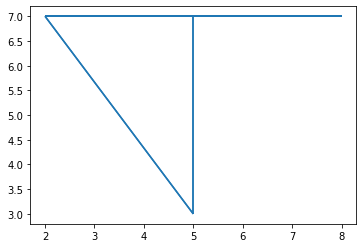

In [16]:
geoms.plot()